# **Housing Market Analysis - Neural Network**

In this demonstration, I will be applying a Neural Network algorithm on the California Housing dataset to predict housing prices.

For more information on the setup, please refer to the "set up and visualiztion" document.

## Setup

Install packages and establish our working environment

In [ ]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 16.7 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
pip install tensorflow

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os
import pandas as pd
# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


## Data

Load and inspect the data

In [ ]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()

import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()

In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
# total_bedrooms has 207 missing values, so I will fill these in with the median value

housing_num = housing.copy()
housing_num['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)
housing_num

<ipython-input-6-2f4b9932421b>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing_num['total_bedrooms'].fillna(housing['total_bedrooms'].median(), inplace=True)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


In [ ]:
ocean_proximity_mapping = {'<1H OCEAN': 0, 'INLAND': 1, 'NEAR OCEAN': 2, 'NEAR BAY': 3, 'ISLAND': 4}

housing_num['ocean_proximity_index'] = housing_num['ocean_proximity'].map(ocean_proximity_mapping)

# for our purposes, establishing an index for ocean_proximity is useful as it is easier to perform this type of analysis on int64 data as opposed to strings.

In [ ]:
housing_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   longitude              20640 non-null  float64
 1   latitude               20640 non-null  float64
 2   housing_median_age     20640 non-null  float64
 3   total_rooms            20640 non-null  float64
 4   total_bedrooms         20640 non-null  float64
 5   population             20640 non-null  float64
 6   households             20640 non-null  float64
 7   median_income          20640 non-null  float64
 8   median_house_value     20640 non-null  float64
 9   ocean_proximity        20640 non-null  object 
 10  ocean_proximity_index  20640 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 1.7+ MB


In [ ]:
# Now create the features(x) and labels(y) vectors by dropping the appropriate variables

X = housing_num.drop(columns=['ocean_proximity', 'median_house_value'])

Y = housing_num["median_house_value"].copy()

Y = Y.to_numpy().reshape(-1, 1)     # we need to make sure that the Y variable is 2D for Keras models

In [ ]:
# establish training, validation, and testing sets

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test = train_test_split(X, random_state=42)
y_train_full, y_test = train_test_split(Y, random_state=42)

X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# at this stage, it is important that I establish these three sets, as they will allow me identify potential risks of overfitting.
# To begin with, I will train the model with the training set data, and evaluate the model's ability to perform out-of-sample prediction on the validation set.
# If the performance of the model is similar between the training and validation set, then I can be confident that the model is not overfitting, and would
# be appropriate to then use on the testing set.

In [ ]:
X_train_full.shape

# This is the shape we expected, which shows us that we are in good order to proceed to our analysis.

# The train-test split by default places 75% of the data in the training set. 75% of 20640 observations is 15480.
# the number of X variables we have is 9.

(15480, 9)

In [ ]:
X_train.shape

# after splitting the full training set into training and validation sets, the training data is again reduced by 25%.
# the anticipated sample size would be 0.75 x 15480 = 11610, which we do see here.

(11610, 9)

In [ ]:
for name, arr in [("y_train_full" ,y_train_full),("y_train", y_train), ("y_valid", y_valid), ("y_test", y_test)]:    # we see the same splitting dostribution with the y variable, and that they all have the required dimensionality
    print(f"{name} shape: {arr.shape}")

y_train_full shape: (15480, 1)
y_train shape: (11610, 1)
y_valid shape: (3870, 1)
y_test shape: (5160, 1)


## Neural Network Model

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Input(shape=(9,)),  # Explicit Input layer
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
# estimate the model

model.compile(loss="rmse", optimizer=keras.optimizers.SGD(learning_rate=1e-2, clipvalue=1.0), metrics=["mae"])
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

# To avoid overfitting, I am including an "early stopping" mechanism with a patience of 10 in this model.
# This means that if there are 10 successive iterations in which there is no improvement, then training will automatically stop and
# the weights from the best performing epoch will be kept.

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 200)                 │           2,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,201 (106.25 KB)

 Trainable params: 27,201 (106.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 28117067776.0000 - mae: 123860.7734 - val_loss: 4464977920.0000 - val_mae: 46525.4414
Epoch 2/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5026327040.0000 - mae: 50331.8594 - val_loss: 4224811264.0000 - val_mae: 44968.4805
Epoch 3/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4857605632.0000 - mae: 48951.6406 - val_loss: 4170874368.0000 - val_mae: 44566.0430
Epoch 4/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4820677632.0000 - mae: 48655.0859 - val_loss: 4151522048.0000 - val_mae: 44386.8594
Epoch 5/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4804053504.0000 - mae: 48527.1953 - val_loss: 4132050432.0000 - val_mae: 44220.5508
Epoch 6/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4786510336.0000 - mae: 48348.0703 - val_loss: 4119024896.0000 - val_mae: 44099.7969
Epoch 7/100
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4748726784.0000 - mae: 48123.7891 - val_loss: 4058973440.0000 - val

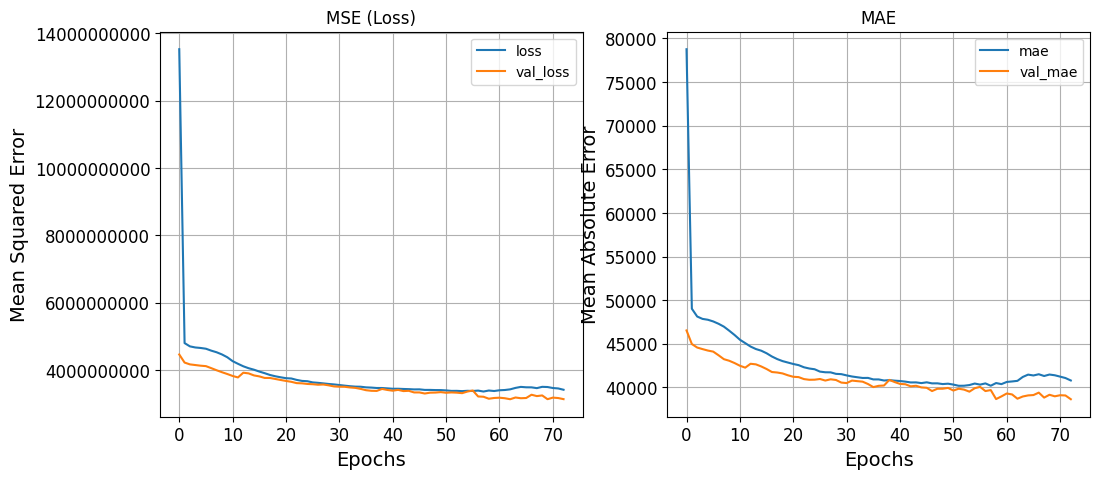

In [ ]:
# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

# Create two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# Plot MSE (Loss)
history_df[["loss", "val_loss"]].plot(ax=axes[0], title="MSE (Loss)", grid=True)
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Mean Squared Error")
axes[0].ticklabel_format(style="plain", axis="y")

# Plot MAE
history_df[["mae", "val_mae"]].plot(ax=axes[1], title="MAE", grid=True)
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Mean Absolute Error")
axes[0].ticklabel_format(style="plain", axis="y")

# Save figures (optional)
plt.savefig("keras_mse_mae_plot.png")

plt.show()

# the early stopping mechanism is triggered at 73 epochs, with our best val_loss occuring at the 63rd epoch. The metric are as follows
#       Epoch 63/100: [loss: 3,472,463,360.0000 - mae: 41,088.7383 - val_loss: 3,136,611,584.0000 - val_mae: 38,701.9883]
#       The loss and val_loss, which are measured by MSE, remain close here. This is a good sign that we have avoided overfitting.
#       Additionally, MAE and val_MAE remain close as well.


#       A quick note about error metrics:
# Mean Squared Error (MSE): this measures the average squared difference between predicted and actual values.
# Mean Absolute Error (MAE): average absolute difference bewteen predicted and actual values.
# A lower score is preferred for both os these metrics, but we never want either to be too close to 0, as that would be a sign of overfitting.

# In machine learning, what we care about is out of sample prediction. This is done by seperating the systematic and random portions of the data.
# Systematic patterns in the data can help us to predict similar patterns in other iterations of the data generating process (DGP), but randomness is not predictable.
# The random fluctuations within an iteration of a DGP will not reliably replicate in further iterations, so are not useful for our purposes.

# Therefore, when a model is too good in-sample, its capturing the unreplicable noise along with the systematic portion.
# The too-good algorithm is learning stuff that it shouldn't be, which is why some error in our models is desirable.

In [ ]:
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:20]
y_pred = model.predict(X_new)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3392017664.0000 - mae: 40606.4844


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [ ]:
X_new = X_test[:20]
y_actual = y_test[:20]  # Actual values
y_pred = model.predict(X_new)  # Predicted values

# Create a DataFrame for better visualization
comparison_df = pd.DataFrame({"Actual": y_actual.flatten(), "Predicted": y_pred.flatten()})

print(comparison_df)

# this allows us to see a comparison of 20 real values in the testing set to the values that the neural network model predicted.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
      Actual      Predicted
0    47700.0   55445.589844
1    45800.0  100005.757812
2   500001.0  413340.437500
3   218600.0  245783.109375
4   278000.0  318981.312500
5   158700.0  156833.484375
6   198200.0  311930.062500
7   157500.0  172025.421875
8   340000.0  236813.156250
9   446600.0  418554.843750
10  123200.0  134794.015625
11  253900.0  173003.296875
12  215100.0  149331.453125
13  220500.0  144812.406250
14  219800.0  237279.234375
15  136200.0  185181.765625
16  178400.0  277775.250000
17  187500.0  214315.656250
18  139800.0  184221.312500
19  137500.0  124197.882812


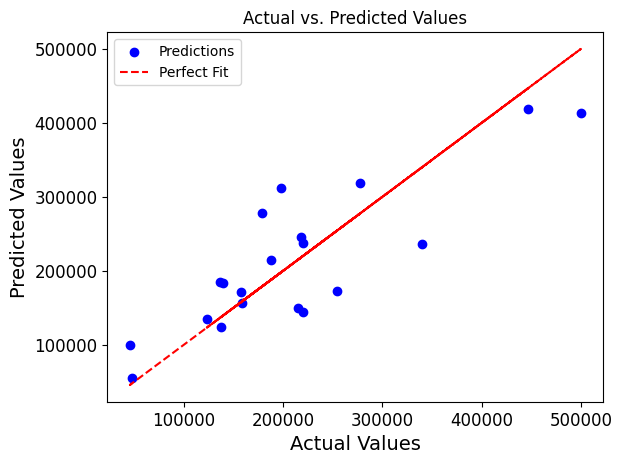

In [ ]:
plt.scatter(y_actual, y_pred, color="blue", label="Predictions")
plt.plot(y_actual, y_actual, color="red", linestyle="--", label="Perfect Fit")  # Diagonal line. The closer a dot is to this line, the better the prediction is.

plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.legend()
plt.show()

# **Conclusion**

With this Neural Network model, I was able to achieve testing-set error metrics of


    Mean Squared Error (MSE): 3,392,017,664.0000
    Mean Absolute Error (MAE): 40,606.4844

The MAE represents an average prediction error of $40,060.48,


which means that on average, the model's predictions deviate from the actual values by about $40,606.48.  
This is well below the standard deviation of 115,395.615874 for median_house_value.

This is likely too high for meaningful house price predictions, but does serve as a strong baseline for future iterations of such a Neural Network with more model complexity. Given increased computing power, a more powerful Neural Network model with more depth (hidden layers) and width (number of neurons), or even an ensemble Neural Network, could be built off of this framework.